<div class="alert alert-block alert-success">
<b>NOTEBOOK 1 - Data Loading
</div>

---
# 1 - IMPORTS

### 1.1 - SETUP PROJECT

Make sure to check `README.md` and `requirements.txt` before running any notebooks. 

In [39]:
# Import modules
import sys
import pickle
import importlib
import pandas as pd
import seaborn as sns  
from pathlib import Path
import matplotlib.pyplot as plt

### 1.2 - DEFINE PATHS

In [42]:
# Paths
PROJECT_PATH = Path.cwd().resolve().parent
DATA_PATH = PROJECT_PATH / "data"
RAW_DATA_PATH = DATA_PATH / "raw"
META_PATH = DATA_PATH / "meta"
SRC_PATH = PROJECT_PATH / "src"
UTILS_PATH = SRC_PATH / "utilities"

# Add src to sys.path (for package-style imports)
if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))

# Add utilities folder to sys.path (for direct import utils)
if str(UTILS_PATH) not in sys.path:
    sys.path.append(str(UTILS_PATH))


# Import with reload
try:
    import utilities.utils as utils
except ModuleNotFoundError:
    import utils

reimport = importlib.reload(utils)

### 1.3 - LOAD DATASET

In [11]:
# Load Data

# Variables & Parameters
file_path = RAW_DATA_PATH / "EIB_Dataset_Climate_Awareness_2024_25.xlsx" 
data_sheet = "A6002_EIB_2024_SPSS_FINAL_23082"
var_labels_sheet = "variable labels"
val_labels_sheet = "value labels"
country_code = 6
null_threshold = 0.10

# Load Excel
all_sheets = pd.read_excel(file_path, sheet_name=None)
df_raw = all_sheets[data_sheet]                             # Main data
var_labels = all_sheets[var_labels_sheet]                   # Variable labels
val_labels = all_sheets[val_labels_sheet]                   # Value labels
print(f"\nTotal columns in dataset: {df_raw.shape[1]}") 
# Filter for country
df_filtered = df_raw[df_raw["country"] == country_code].copy()

# Drop standard metadata columns if present
metadata_cols = ["uuid", "record", "language", "Weight in the EU"]
df_filtered.drop(columns=[col for col in metadata_cols if col in df_filtered.columns], inplace=True)

# Treat empty strings or whitespace as NaN
df_replaced = df_filtered.replace(r'^\s*$', pd.NA, regex=True)

# Calculate null ratio
null_ratio = df_replaced.isna().mean()

# Identify columns to drop
dropped_cols = null_ratio[null_ratio > null_threshold].index.tolist()

if dropped_cols:
    print(f"Dropping {len(dropped_cols)} columns with >{int(null_threshold * 100)}% missing values:")
    print(dropped_cols)

# Apply column drop
df_filtered = df_filtered.loc[:, null_ratio <= null_threshold]
print(f"\nTotal columns in dataset: {df_filtered.shape[1]}") 

# Final list of columns in cleaned DataFrame
final_columns = set(df_filtered.columns)

# Build variable label dictionary (column descriptions)
var_dict = dict(zip(var_labels["Variable"], var_labels["Libellé"]))
var_dict = {k: v for k, v in var_dict.items() if k in final_columns}

# Build value decoding dictionary
val_dict = {}
current_var = None
for _, row in val_labels.iterrows():
    if pd.notna(row["Valeurs des variables"]):
        current_var = row["Valeurs des variables"]
        if current_var in final_columns:
            val_dict[current_var] = {}
    if current_var in val_dict and pd.notna(row["Unnamed: 1"]) and pd.notna(row["Unnamed: 2"]):
        val_dict[current_var][row["Unnamed: 1"]] = row["Unnamed: 2"]

val_dict.pop("Valeur", None)  # Remove any residual useless key


Total columns in dataset: 158
Dropping 69 columns with >10% missing values:
['qc1', 'qc2', 'qc3', 'sd4at', 'sd4be', 'sd4bg', 'sd4hr', 'sd4cz', 'sd4dk', 'sd4ee', 'sd4fi', 'sd4firecode', 'sd4fr', 'sd4de', 'sd4gr', 'sd4grrecode', 'sd4hu', 'sd4hurecode', 'sd4ie', 'sd4lv', 'sd4lt', 'sd4nl', 'sd4pl', 'sd4pt', 'sd4ro', 'sd4si', 'sd4sk', 'sd4es', 'sd4se', 'sd4serecode', 'sd4us', 'sd4usrecode', 'sd5at', 'sd5be', 'sd5bg', 'sd5cy', 'sd5hr', 'sd5cz', 'sd5dk', 'sd5ee', 'sd5fi', 'sd5fr', 'sd5de', 'sd5gr', 'sd5hu', 'sd5ie', 'sd5lv', 'sd5lt', 'sd5lu', 'sd5mt', 'sd5nl', 'sd5pl', 'sd5pt', 'sd5ro', 'sd5si', 'sd5sk', 'sd5es', 'sd5se', 'sd5us', 'sd7', 'Q1_2024r2', 'q11bis', 'q17r1', 'q17r2', 'q17r3', 'q17r4', 'q17r5', 'q17r6', 'q17r7']

Total columns in dataset: 87


In [12]:
# Results
display(df_filtered)   # cleaned DataFrame
print(var_dict)        # variable name dictionary
print(val_dict)        # value decoding dictionary
print(dropped_cols)    # list of dropped columns

,country,sd2,origage,sd8,mpq,mpq2,sd8recode,agerecode,sd1,sd3,...,q13r8,q14,q15,q16_dupe1,q18_dupe1,q19_dupe1,q20_dupe1,q21,q22,Weight in the country
1,6,67,5,2,1,1,2,5,1,12,...,0,3,2,1,3,2,2,1,1,1.102596
4,6,65,5,2,1,1,2,5,1,11,...,0,2,2,2,2,3,1,2,2,1.042332
7,6,36,3,2,1,1,2,3,2,11,...,0,3,2,3,5,3,2,2,3,0.961171
8,6,36,3,2,1,1,2,3,1,11,...,0,3,2,3,1,3,2,2,2,1.089805
9,6,34,3,2,1,1,2,3,2,4,...,0,2,1,2,3,2,2,1,1,0.950834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21512,6,54,4,2,1,2,2,4,1,1,...,0,3,2,1,1,3,2,1,1,0.908334
21517,6,66,5,2,1,2,2,5,2,9,...,0,3,2,1,5,4,2,2,2,0.882654
21520,6,70,5,2,1,2,2,5,2,12,...,0,2,2,1,2,1,2,1,1,0.935720
21522,6,39,3,1,1,2,1,3,1,4,...,0,2,1,1,3,2,2,1,1,0.949402


{'country': 'country: Country:', 'sd2': 'sd2: How old are you?', 'origage': 'origage: New Single Select Question', 'sd8': 'sd8: Do you have children under 18 years old?', 'mpq': 'mpq: Ask qc1?', 'mpq2': 'mpq2: Ask qc1?', 'sd8recode': 'sd8recode: Do you have children under 18 years old?', 'agerecode': 'agerecode: New Single Select Question', 'sd1': 'sd1: Please indicate your gender.', 'sd3': 'sd3: What is your current occupation?', 'occupation': 'occupation: New Single Select Question', 'sd4it': 'sd4it: Where do you live?', 'sd5it': 'sd5it: What is your annual net income?', 'sd6': 'sd6: The following question relates to your political preferences. Your answer will only be used to analyse the results of this survey and will be made anonymous.Do you give consent for this information to be collected?', 'sd6b': 'sd6b: When discussing politics, people often mention “right” and “left”. Where would you say your political position lies on this scale?', 'SD8_dupe1': 'SD8_dupe1: What is the highe

In [ ]:
# Save var_dict and val_dict to data/meta/
META_PATH.mkdir(parents=True, exist_ok=True)

with open(META_PATH / "var_dict.pkl", "wb") as f:
    pickle.dump(var_dict, f)

with open(META_PATH / "val_dict.pkl", "wb") as f:
    pickle.dump(val_dict, f)

print("Dictionaries saved to:", META_PATH)

Dictionaries saved to: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Clustering\Mapping_The_Italian_Climate_Mindscape\data\meta


In [13]:
# Explore Data
df = df_filtered.copy()

df = df.reset_index(drop=True)
print(f"\nTotal columns in dataset: {df.shape[1]}") 

# Drop country column
df.drop(columns=["country"], inplace=True, errors='ignore') # delete country column now redundant
var_dict.pop("country", None)
val_dict.pop("country", None)

display(df)
print("Dataset shape:", df.shape)

print("\nDataset head:")
display(df.head())

print('\nDataset info')
print(df.info())

print("\nColumn types:")
print(df.dtypes.value_counts())
unique_counts = df.nunique().sort_values()

print("Number of unique values per column:")
display(unique_counts.to_frame("Unique Values")) 


Total columns in dataset: 87


,sd2,origage,sd8,mpq,mpq2,sd8recode,agerecode,sd1,sd3,occupation,...,q13r8,q14,q15,q16_dupe1,q18_dupe1,q19_dupe1,q20_dupe1,q21,q22,Weight in the country
0,67,5,2,1,1,2,5,1,12,3,...,0,3,2,1,3,2,2,1,1,1.102596
1,65,5,2,1,1,2,5,1,11,2,...,0,2,2,2,2,3,1,2,2,1.042332
2,36,3,2,1,1,2,3,2,11,2,...,0,3,2,3,5,3,2,2,3,0.961171
3,36,3,2,1,1,2,3,1,11,2,...,0,3,2,3,1,3,2,2,2,1.089805
4,34,3,2,1,1,2,3,2,4,1,...,0,2,1,2,3,2,2,1,1,0.950834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,54,4,2,1,2,2,4,1,1,1,...,0,3,2,1,1,3,2,1,1,0.908334
1004,66,5,2,1,2,2,5,2,9,1,...,0,3,2,1,5,4,2,2,2,0.882654
1005,70,5,2,1,2,2,5,2,12,3,...,0,2,2,1,2,1,2,1,1,0.935720
1006,39,3,1,1,2,1,3,1,4,1,...,0,2,1,1,3,2,2,1,1,0.949402


Dataset shape: (1008, 86)

Dataset head:


,sd2,origage,sd8,mpq,mpq2,sd8recode,agerecode,sd1,sd3,occupation,...,q13r8,q14,q15,q16_dupe1,q18_dupe1,q19_dupe1,q20_dupe1,q21,q22,Weight in the country
0,67,5,2,1,1,2,5,1,12,3,...,0,3,2,1,3,2,2,1,1,1.102596
1,65,5,2,1,1,2,5,1,11,2,...,0,2,2,2,2,3,1,2,2,1.042332
2,36,3,2,1,1,2,3,2,11,2,...,0,3,2,3,5,3,2,2,3,0.961171
3,36,3,2,1,1,2,3,1,11,2,...,0,3,2,3,1,3,2,2,2,1.089805
4,34,3,2,1,1,2,3,2,4,1,...,0,2,1,2,3,2,2,1,1,0.950834



Dataset info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 86 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sd2                    1008 non-null   int64  
 1   origage                1008 non-null   int64  
 2   sd8                    1008 non-null   int64  
 3   mpq                    1008 non-null   int64  
 4   mpq2                   1008 non-null   int64  
 5   sd8recode              1008 non-null   int64  
 6   agerecode              1008 non-null   int64  
 7   sd1                    1008 non-null   int64  
 8   sd3                    1008 non-null   int64  
 9   occupation             1008 non-null   int64  
 10  sd4it                  1008 non-null   float64
 11  sd5it                  1008 non-null   float64
 12  sd6                    1008 non-null   int64  
 13  sd6b                   966 non-null    float64
 14  SD8_dupe1              1008 non-null   int

,Unique Values
mpq,2
sd8,2
sd8recode,2
mpq2,2
sd1,2
...,...
sd6b,11
sd3,12
sd4it,21
sd2,70


sd2, 0, 0.0%
origage, 0, 0.0%
sd8, 0, 0.0%
mpq, 0, 0.0%
mpq2, 0, 0.0%
sd8recode, 0, 0.0%
agerecode, 0, 0.0%
sd1, 0, 0.0%
sd3, 0, 0.0%
occupation, 0, 0.0%
sd4it, 0, 0.0%
sd5it, 0, 0.0%
sd6, 0, 0.0%
sd6b, 42, 4.17%
SD8_dupe1, 0, 0.0%
SD8recode_dupe1, 0, 0.0%
Q1_2024r1, 0, 0.0%
Q1_2024r13, 0, 0.0%
Q1_2024r14, 0, 0.0%
Q1_2024r3, 0, 0.0%
Q1_2024r4, 0, 0.0%
Q1_2024r15, 0, 0.0%
Q1_2024r5, 0, 0.0%
Q1_2024r6, 0, 0.0%
Q1_2024r7, 0, 0.0%
Q1_2024r8, 0, 0.0%
Q1_2024r9, 0, 0.0%
Q1_2024r10, 0, 0.0%
Q1_2024r11, 0, 0.0%
Q1_2024r12, 0, 0.0%
q2_dupe1, 0, 0.0%
q3_dupe1, 0, 0.0%
q4r1, 0, 0.0%
q4r2, 0, 0.0%
q5r1, 0, 0.0%
q5r2, 0, 0.0%
q5r3, 0, 0.0%
q5r4, 0, 0.0%
q5r5, 0, 0.0%
q5r6, 0, 0.0%
q5r7, 0, 0.0%
q5r8, 0, 0.0%
q5r9, 0, 0.0%
q6r1, 0, 0.0%
q6r2, 0, 0.0%
q6r3, 0, 0.0%
q6r4, 0, 0.0%
q6r5, 0, 0.0%
q6r6, 0, 0.0%
q6r7, 0, 0.0%
q6r8, 0, 0.0%
q6r9, 0, 0.0%
q6r10, 0, 0.0%
q6r11, 0, 0.0%
q7_dupe1, 0, 0.0%
q8_dupe1, 0, 0.0%
q9_dupe1, 0, 0.0%
q10r1_dupe1, 0, 0.0%
q10r2_dupe1, 0, 0.0%
q11_dupe1, 0, 0.0%
q12r1, 0, 

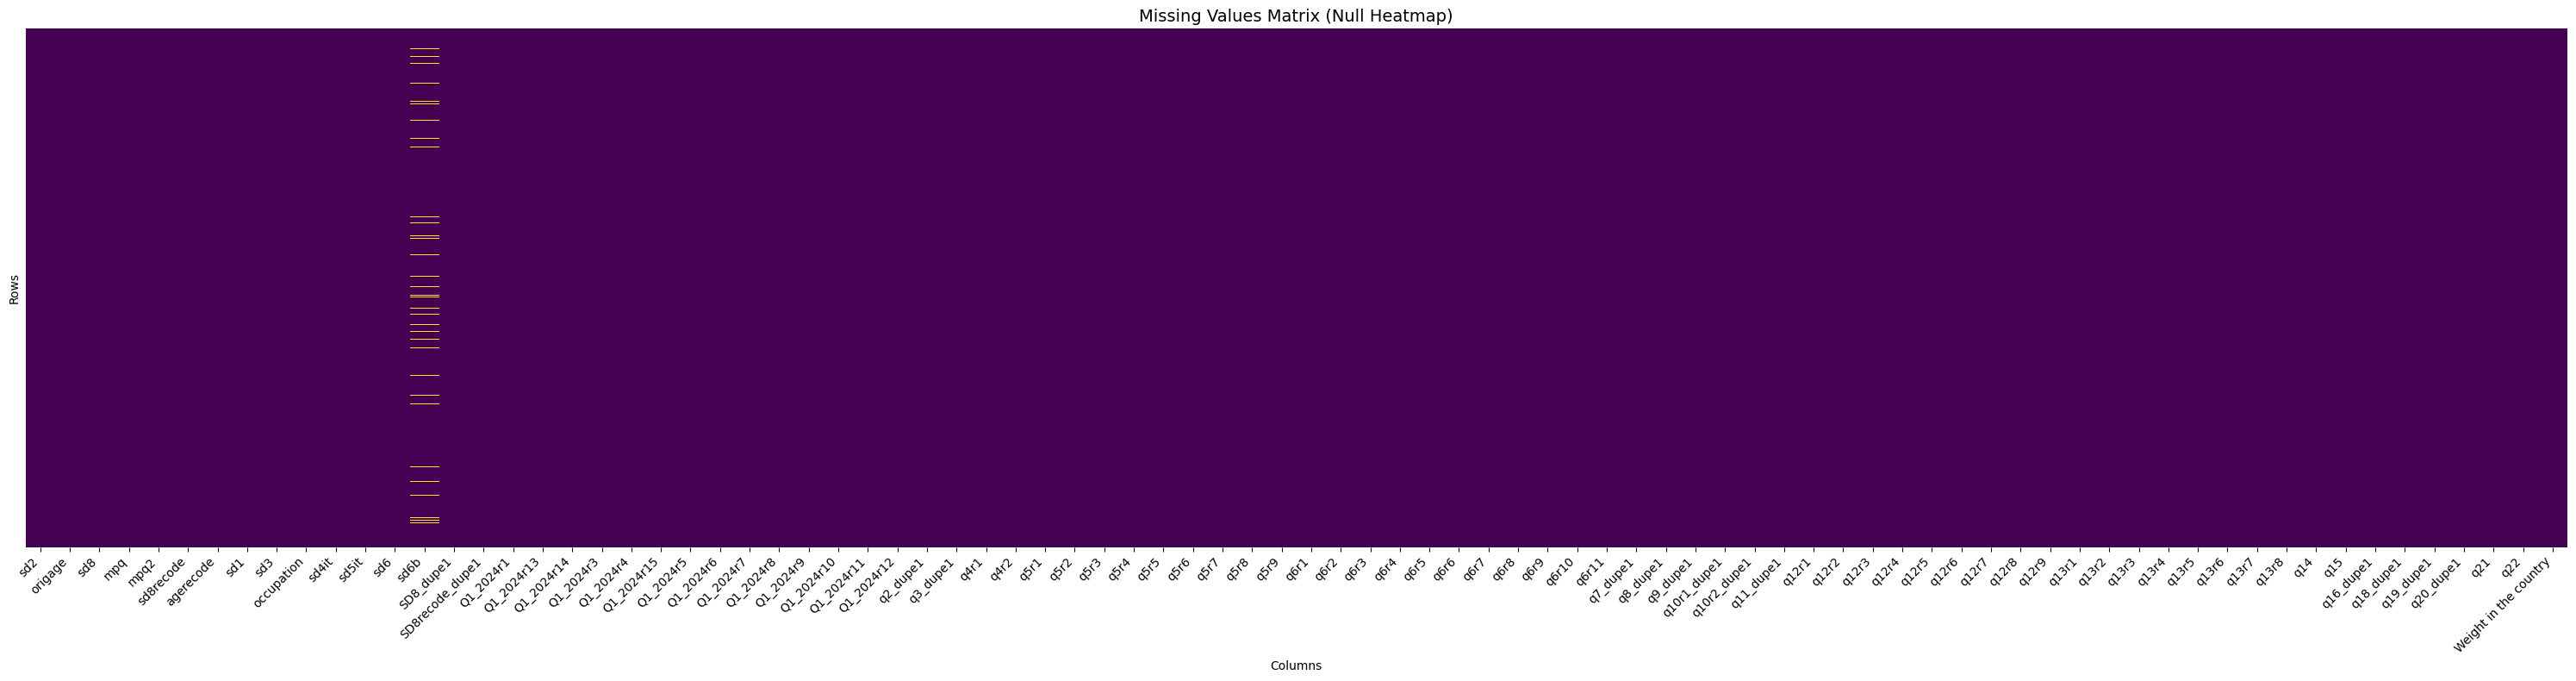

In [14]:
nulls_sum = {}

for key in var_dict:
    sum_miss_count = df[key].isnull().sum()
    total_rows = len(df[key])
    if sum_miss_count > 0:
        percent_miss_count = round((sum_miss_count / total_rows) * 100, 2)
    else:
        percent_miss_count = 0.0
    nulls_sum[key] = {
        'Missing Values': int(sum_miss_count),
        'Missing %': float(percent_miss_count)
    }

# Print the results in a clean format
for key, stats in nulls_sum.items():
    print(f"{key}, {stats['Missing Values']}, {stats['Missing %']}%")

# Plot null matrix heatmap         
plt.figure(figsize=(30, 8))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values Matrix (Null Heatmap)', fontsize=14)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
# Print number of columns in total

In [44]:
utils.save_dataset(df, "01_climate_dataset_filtered.xlsx", "interim")

File saved as: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Clustering\Mapping_The_Italian_Climate_Mindscape\data\interim\01_climate_dataset_filtered.xlsx


<div class="alert alert-block alert-info">
<b>Next Notebook - Data Cleaning
</div>